In [1]:
!pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/920.8 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 786.4/920.8 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 920.8/920.8 kB 870.1 kB/s  0:00:00


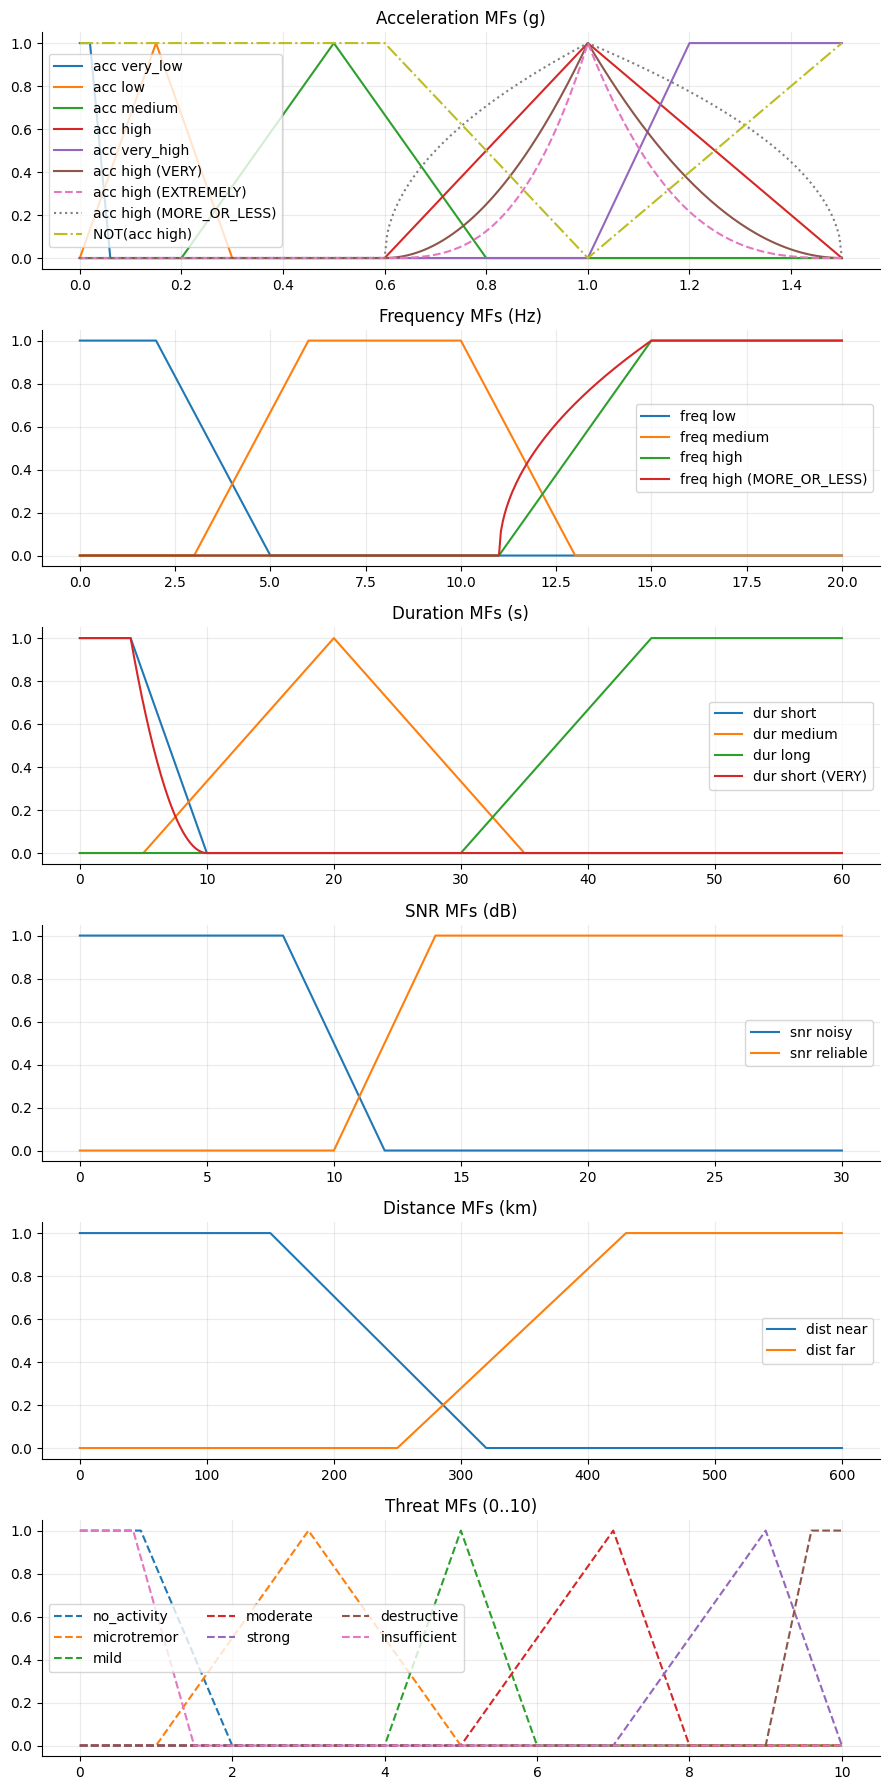

### Fuzzy Rules

HTML(value="<pre style='white-space:pre-wrap'>R0a IF snr is noisy AND acc is very_low AND dist is far         …

Button(button_style='primary', description='Compute', style=ButtonStyle())

Output()

Output()

Output()

In [10]:
# ===========================================
# FUZZY EXPERT SYSTEM — EARTHQUAKE THREAT (Mamdani/Larsen)
# This revision applies ONLY the requested items:
# 1) Generalize modifiers (hedges) and expose them (VERY, EXTREMELY, MORE_OR_LESS, NOT)
# 2) Support NOT and composite antecedents declaratively (helpers) — rules kept as-is
# 3) Operator presets + titles everywhere (plots + UI banner with warnings)
# 4) Input clipping warning exposed (metadata surfaced in UI/CLI)
# 5) Expose per-rule weights in UI/CLI
# 6) Fix plot annotation to reflect current implication
# 7) Fix no_rule_fired_rate to match docstring (simulate implication+aggregation)
# (Everything else remains unchanged.)
# ===========================================

from typing import Dict, List, Tuple, Optional
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# ----------------------------
# 0) PARAMETERS (easy to tweak)
# ----------------------------
# Universes
X_ACC_MAX   = 1.5
X_FREQ_MAX  = 20.0
X_DUR_MAX   = 60.0
X_SNR_MAX   = 30.0
X_DIST_MAX  = 600.0
X_THREAT_MAX = 10.0

# Grids
x_acc    = np.linspace(0.0, X_ACC_MAX, 301)        # ground acceleration (g)
x_freq   = np.linspace(0.0, X_FREQ_MAX, 401)       # dominant frequency (Hz)
x_dur    = np.linspace(0.0, X_DUR_MAX, 601)        # event duration (s)
x_snr    = np.linspace(0.0, X_SNR_MAX, 301)        # SNR (dB)
x_dist   = np.linspace(0.0, X_DIST_MAX, 601)       # epicentral distance (km)
x_threat = np.linspace(0.0, X_THREAT_MAX, 1001)    # threat (0..10)

# Label tie-break policy when μs are ~tied at the crisp point.
# "lower"  → prefer lower-severity label on near-ties (conservative)
# "higher" → prefer higher-severity label on near-ties (alarmist)
TIE_BREAK_POLICY = "lower"
TIE_EPS = 1e-2  # relaxed per request

# Severity ordering from low → high (used for deterministic tie-break)
SEVERITY_ORDER = [
    "insufficient",
    "no_activity", "microtremor", "mild",
    "moderate", "strong", "destructive"
]

# Health-check thresholds
PEAK_THR_BASE = 0.999   # base sets should peak ~1
PEAK_THR_MODS = 0.90    # modifier-derived sets (hedges) may peak < 1

# ----------------------------
# 0.1) FUZZY CONFIG (requested)
# ----------------------------
# Supported modes:
#   tnorm: 'min' | 'prod'
#   snorm: 'max' | 'bsum' (bounded sum) | 'asum' (algebraic sum)
#   aggregator: same set as snorm, applied element-wise to consequent sets
FUZZY_CFG = {
    "tnorm": "min",
    "snorm": "max",
    "aggregator": "max",
}

VALID_TNORMS = {"min", "prod"}
VALID_SNORMS = {"max", "bsum", "asum"}
VALID_AGGS   = {"max", "bsum", "asum"}

def _validate_ops(tnorm: str, snorm: str, aggregator: Optional[str] = None) -> None:
    if tnorm not in VALID_TNORMS:
        raise ValueError(f"Unsupported t-norm '{tnorm}'. Supported: {sorted(VALID_TNORMS)}")
    if snorm not in VALID_SNORMS:
        raise ValueError(f"Unsupported s-norm '{snorm}'. Supported: {sorted(VALID_SNORMS)}")
    if aggregator is not None and aggregator not in VALID_AGGS:
        raise ValueError(f"Unsupported aggregator '{aggregator}'. Supported: {sorted(VALID_AGGS)}")

# Optional per-rule weights (scalar in [0,1]); default 1.0 for all rules.
RULE_TAGS = ["R0a","R0b","R1","R2","R3","R4","R5","R6","R7","R8","R9",
             "R10","R11","R12","R13","R14","R15","R16","R17","R18"]
RULE_WEIGHTS_DEFAULT: Dict[str, float] = {t: 1.0 for t in RULE_TAGS}

# -----------------------------
# Helper ops for fuzzy calculus
# -----------------------------
def _tnorm2(a: float, b: float, mode: str) -> float:
    if mode == "prod":
        return float(a * b)
    if mode == "min":
        return float(min(a, b))
    raise ValueError(f"Unsupported t-norm '{mode}'")

def _snorm2(a: float, b: float, mode: str) -> float:
    if mode == "bsum":   # bounded sum
        return float(min(1.0, a + b))
    if mode == "asum":   # algebraic sum
        return float(a + b - a * b)
    if mode == "max":
        return float(max(a, b))
    raise ValueError(f"Unsupported s-norm '{mode}'")

def _tnorm_n(vals: List[float], mode: str) -> float:
    if not vals: return 0.0
    acc = float(vals[0])
    for v in vals[1:]:
        acc = _tnorm2(acc, float(v), mode)
    return float(acc)

def _snorm_n(vals: List[float], mode: str) -> float:
    if not vals: return 0.0
    acc = float(vals[0])
    for v in vals[1:]:
        acc = _snorm2(acc, float(v), mode)
    return float(acc)

def _agg_arrays(a: np.ndarray, b: np.ndarray, mode: str) -> np.ndarray:
    if mode == "bsum":
        return np.clip(a + b, 0.0, 1.0)
    if mode == "asum":
        return np.clip(a + b - a * b, 0.0, 1.0)
    if mode == "max":
        return np.fmax(a, b)
    raise ValueError(f"Unsupported aggregator '{mode}'")

# -----------------------------
# 0.2) HEDGES (generic registry)
# -----------------------------
# Applied to membership arrays; names are exposed in mu_* dicts as suffix/prefix:
# - "<label>_very", "<label>_extremely", "<label>_more_or_less", "not_<label>"
HEDGES = {
    "VERY": lambda μ: np.power(μ, 2.0),
    "EXTREMELY": lambda μ: np.power(μ, 3.0),
    "MORE_OR_LESS": np.sqrt,
    "NOT": lambda μ: 1.0 - μ,
}
# lowercase accessors for convenience
_HEDGE_ALIASES = {
    "very": "VERY",
    "extremely": "EXTREMELY",
    "more_or_less": "MORE_OR_LESS",
    "somewhat": "MORE_OR_LESS",   # synonym to match earlier 'some'
    "not": "NOT",
}

def _hedge_arr(arr: np.ndarray, name: str) -> np.ndarray:
    key = _HEDGE_ALIASES.get(name.lower(), name.upper())
    if key not in HEDGES:
        raise ValueError(f"Unknown hedge '{name}'")
    return np.clip(HEDGES[key](arr), 0.0, 1.0)

# ----------------------------------
# 1) MEMBERSHIP FUNCTIONS (MFs)
# ----------------------------------
# 1.1 Acceleration
acc_very_low  = fuzz.trapmf(x_acc,  [0.00, 0.00, 0.02, 0.06])
acc_low       = fuzz.trimf (x_acc,  [0.00, 0.15, 0.30])
acc_medium    = fuzz.trimf (x_acc,  [0.20, 0.50, 0.80])
acc_high      = fuzz.trimf (x_acc,  [0.60, 1.00, 1.50])
acc_very_high = fuzz.trapmf(x_acc,  [1.00, 1.20, 1.50, 1.50])

# Previous ad-hoc modifiers (kept as aliases)
acc_high_very = _hedge_arr(acc_high, "VERY")

# 1.2 Frequency
freq_low    = fuzz.trapmf(x_freq, [0.0, 0.0, 2.0, 5.0])
freq_medium = fuzz.trapmf(x_freq, [3.0, 6.0,10.0,13.0])
freq_high   = fuzz.trapmf(x_freq, [11.0,15.0,20.0,20.0])

# Previous ad-hoc modifier alias
freq_high_some = _hedge_arr(freq_high, "MORE_OR_LESS")

# 1.3 Duration
dur_short  = fuzz.trapmf(x_dur, [0.0, 0.0, 4.0, 10.0])
dur_medium = fuzz.trimf (x_dur, [5.0, 20.0, 35.0])
dur_long   = fuzz.trapmf(x_dur, [30.0, 45.0, 60.0, 60.0])
dur_short_very = _hedge_arr(dur_short, "VERY")

# 1.4 SNR
snr_noisy     = fuzz.trapmf(x_snr, [0.0, 0.0, 8.0, 12.0])
snr_reliable  = fuzz.trapmf(x_snr, [10.0,14.0,30.0,30.0])

# 1.5 Distance
dist_near = fuzz.trapmf(x_dist, [0.0, 0.0,150.0,320.0])
dist_far  = fuzz.trapmf(x_dist, [250.0,430.0,600.0,600.0])

# 1.6 Output: THREAT
th_no_activity  = fuzz.trapmf(x_threat, [0.0, 0.0, 0.8, 2.0])     # no_activity
th_microtremor  = fuzz.trimf (x_threat, [1.0, 3.0, 5.0])          # microtremor
th_mild         = fuzz.trimf (x_threat, [4.0, 5.0, 6.0])          # mild
th_moderate     = fuzz.trimf (x_threat, [5.0, 7.0, 8.0])          # moderate
th_strong       = fuzz.trimf (x_threat, [7.0, 9.0,10.0])          # strong
th_destructive  = fuzz.trapmf(x_threat, [9.0, 9.6,10.0,10.0])     # destructive
th_insufficient = fuzz.trapmf(x_threat, [0.0, 0.0, 0.7, 1.5])     # insufficient

# Helper: consequents dictionary
THSETS = {
    "no_activity":  th_no_activity,
    "microtremor":  th_microtremor,
    "mild":         th_mild,
    "moderate":     th_moderate,
    "strong":       th_strong,
    "destructive":  th_destructive,
    "insufficient": th_insufficient,
}

# Label mapping (EN → EN; identity kept for compatibility)
LABEL_MAP = {
    "no_activity":  "No seismic activity",
    "microtremor":  "Microtremor",
    "mild":         "Mild earthquake",
    "moderate":     "Moderate earthquake",
    "strong":       "Strong earthquake",
    "destructive":  "Destructive earthquake",
    "insufficient": "Insufficient evidence",
}

# ---------------------------
# 2) FUZZIFICATION HELPERS
# ---------------------------
def _interp_memberships(universe: np.ndarray, sets: Dict[str, np.ndarray], x: float) -> Dict[str, float]:
    res = {name: float(fuzz.interp_membership(universe, arr, x)) for name, arr in sets.items()}
    return res

def _augment_with_hedges(base_sets: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Given base sets (e.g., {'low': arr, 'medium': arr, ...}), produce:
      - '<label>_very', '<label>_extremely', '<label>_more_or_less'
      - 'not_<label>' (complement)
    """
    augmented = dict(base_sets)
    for name, arr in base_sets.items():
        augmented[f"{name}_very"]         = _hedge_arr(arr, "VERY")
        augmented[f"{name}_extremely"]    = _hedge_arr(arr, "EXTREMELY")
        augmented[f"{name}_more_or_less"] = _hedge_arr(arr, "MORE_OR_LESS")
        augmented[f"not_{name}"]          = _hedge_arr(arr, "NOT")
    return augmented

# Build per-domain dictionaries (with hedges auto-exposed)
ACC_SETS = _augment_with_hedges({
    "very_low":  acc_very_low, "low": acc_low, "medium": acc_medium,
    "high": acc_high, "very_high": acc_very_high,
    # compatibility alias:
    "high_very": acc_high_very
})
FREQ_SETS = _augment_with_hedges({
    "low": freq_low, "medium": freq_medium, "high": freq_high,
    # compatibility alias:
    "high_some": freq_high_some
})
DUR_SETS = _augment_with_hedges({
    "short": dur_short, "medium": dur_medium, "long": dur_long,
    # compatibility alias:
    "short_very": dur_short_very
})
SNR_SETS  = _augment_with_hedges({"noisy": snr_noisy, "reliable": snr_reliable})
DIST_SETS = _augment_with_hedges({"near": dist_near, "far": dist_far})

def mu_acc(a: float) -> Dict[str, float]:
    return _interp_memberships(x_acc, ACC_SETS, a)

def mu_freq(f: float) -> Dict[str, float]:
    return _interp_memberships(x_freq, FREQ_SETS, f)

def mu_dur(d: float) -> Dict[str, float]:
    return _interp_memberships(x_dur, DUR_SETS, d)

def mu_snr(s: float) -> Dict[str, float]:
    return _interp_memberships(x_snr, SNR_SETS, s)

def mu_dist(x: float) -> Dict[str, float]:
    return _interp_memberships(x_dist, DIST_SETS, x)

# ---------------------------------------------
# 2.1) Declarative combinators for antecedents
# ---------------------------------------------
# These helpers allow nested composites with NOT/AND/OR while keeping rules as-is.
def NOT(v: float) -> float:
    return float(1.0 - np.clip(v, 0.0, 1.0))

def AND(vals: List[float], tnorm: str) -> float:
    return _tnorm_n(vals, tnorm)

def OR(vals: List[float], snorm: str) -> float:
    return _snorm_n(vals, snorm)

def term(mu_dict: Dict[str, float], key: str) -> float:
    """
    Access a membership degree by key with optional 'not_' prefix or hedge suffixes.
    Keys are expected to be present because mu_* exposes them.
    """
    if key in mu_dict:
        return float(mu_dict[key])
    # allow 'NOT label' with space, and 'label:very' chain
    k = key.strip()
    if k.lower().startswith("not "):
        base = k[4:].strip()
        return NOT(float(mu_dict[base]))
    if ":" in k:
        base, *mods = [p.strip() for p in k.split(":")]
        # compose suffix like base_mod1_mod2
        suffix = "_".join([m.lower() for m in mods])
        composed = f"{base}_{suffix}"
        if composed in mu_dict:
            return float(mu_dict[composed])
    raise KeyError(f"Unknown term key '{key}'")

# ---------------------------------------------
# 3) RULES (R0..R18) — centralized computation
#    AND/OR use configurable t-norm / s-norm (requested).
#    Per-rule weights applied before implication (requested).
# ---------------------------------------------
RULES_DOC = r"""
R0a IF snr is noisy AND acc is very_low AND dist is far                  THEN threat is insufficient
R0b IF snr is noisy AND dur is short     AND dist is far                  THEN threat is insufficient

R1  IF acc is high AND dur is short AND dist is near AND snr is reliable  THEN threat is strong
R2  IF acc is high AND dur is long  AND dist is near AND snr is reliable  THEN threat is destructive
R3  IF acc is high AND freq is high AND dist is near AND snr is reliable  THEN threat is strong
R4  IF acc is high AND dist is far  AND snr is reliable                   THEN threat is moderate
R5  IF acc is medium AND freq is high AND dist is near AND snr is reliable THEN threat is mild
R6  IF acc is medium AND dur is medium AND dist is near AND snr is reliable THEN threat is moderate
R7  IF acc is medium AND dur is long   AND dist is near AND snr is reliable THEN threat is moderate
R8  IF acc is low    AND freq is high AND dur is short AND snr is reliable THEN threat is no_activity
R9  IF acc is low    AND dur is short AND dist is far  AND snr is reliable THEN threat is no_activity
R10 IF acc is low    AND dur is long  AND dist is near AND snr is reliable THEN threat is microtremor
R11 IF freq is low   AND dur is long  AND dist is near AND snr is reliable THEN threat is strong

-- noisy evidence (noisy snr) → conservative mapping (never above 'moderate') --
R12 IF snr is noisy AND acc is high   AND dist is near                    THEN threat is moderate
R13 IF snr is noisy AND acc is medium AND dist is near                    THEN threat is mild
R14 IF snr is noisy AND acc is low                                         THEN threat is microtremor
R15 IF snr is noisy AND dist is far                                        THEN threat is no_activity

-- general distance/effect trade-offs --
R16 IF dist is near AND (acc is medium OR freq is high) AND snr is reliable THEN threat is moderate
R17 IF dist is far  AND acc is low AND dur is medium AND snr is reliable    THEN threat is microtremor

-- high-intensity corner (using modifiers per theory) --
R18 IF acc is high_very AND freq is high_some AND dur is long AND dist is near
    AND snr is reliable                                                     THEN threat is destructive
""".strip()

def compute_rule_strengths(
    muA: Dict[str, float], muF: Dict[str, float], muD: Dict[str, float],
    muS: Dict[str, float], muX: Dict[str, float],
    *, tnorm: str = None, snorm: str = None, rule_weights: Optional[Dict[str, float]] = None
) -> List[Tuple[float, str, str]]:
    """
    Compute antecedent strengths for all rules using configurable t-norm (AND) and s-norm (OR).
    Applies per-rule weight w[tag] in [0,1] BEFORE implication, i.e., strength := w[tag] * strength.
    Returns list of (strength, consequent_name, rule_tag).
    """
    tnorm = (tnorm or FUZZY_CFG["tnorm"]).lower()
    snorm = (snorm or FUZZY_CFG["snorm"]).lower()
    _validate_ops(tnorm, snorm)  # fail fast on invalid names
    w = (rule_weights or RULE_WEIGHTS_DEFAULT)

    out: List[Tuple[float, str, str]] = []

    # R0a / R0b
    r = AND([muS["noisy"], muA["very_low"], muX["far"]], tnorm); out.append((w["R0a"] * float(r), "insufficient", "R0a"))
    r = AND([muS["noisy"], muD["short"],    muX["far"]], tnorm); out.append((w["R0b"] * float(r), "insufficient", "R0b"))

    # R1..R11
    r = AND([muA["high"],  muD["short"], muX["near"], muS["reliable"]], tnorm); out.append((w["R1"]  * float(r), "strong",       "R1"))
    r = AND([muA["high"],  muD["long"],  muX["near"], muS["reliable"]], tnorm); out.append((w["R2"]  * float(r), "destructive",  "R2"))
    r = AND([muA["high"],  muF["high"],  muX["near"], muS["reliable"]], tnorm); out.append((w["R3"]  * float(r), "strong",       "R3"))
    r = AND([muA["high"],  muX["far"],   muS["reliable"]],               tnorm); out.append((w["R4"]  * float(r), "moderate",     "R4"))
    r = AND([muA["medium"],muF["high"],  muX["near"], muS["reliable"]],  tnorm); out.append((w["R5"]  * float(r), "mild",         "R5"))
    r = AND([muA["medium"],muD["medium"],muX["near"], muS["reliable"]],  tnorm); out.append((w["R6"]  * float(r), "moderate",     "R6"))
    r = AND([muA["medium"],muD["long"],  muX["near"], muS["reliable"]],  tnorm); out.append((w["R7"]  * float(r), "moderate",     "R7"))
    r = AND([muA["low"],   muF["high"],  muD["short"], muS["reliable"]],  tnorm); out.append((w["R8"]  * float(r), "no_activity",  "R8"))
    r = AND([muA["low"],   muD["short"], muX["far"],  muS["reliable"]],  tnorm); out.append((w["R9"]  * float(r), "no_activity",  "R9"))
    r = AND([muA["low"],   muD["long"],  muX["near"], muS["reliable"]],  tnorm); out.append((w["R10"] * float(r), "microtremor",  "R10"))
    r = AND([muF["low"],   muD["long"],  muX["near"], muS["reliable"]],  tnorm); out.append((w["R11"] * float(r), "strong",       "R11"))

    # R12..R15 (noisy)
    r = AND([muS["noisy"], muA["high"],   muX["near"]], tnorm); out.append((w["R12"] * float(r), "moderate",     "R12"))
    r = AND([muS["noisy"], muA["medium"], muX["near"]], tnorm); out.append((w["R13"] * float(r), "mild",         "R13"))
    r = AND([muS["noisy"], muA["low"]],                 tnorm); out.append((w["R14"] * float(r), "microtremor",  "R14"))
    r = AND([muS["noisy"], muX["far"]],                 tnorm); out.append((w["R15"] * float(r), "no_activity",  "R15"))

    # R16 trade-off (explicit OR via chosen s-norm)
    or_term = OR([muA["medium"], muF["high"]], snorm)
    r = AND([muX["near"], or_term, muS["reliable"]], tnorm)
    out.append((w["R16"] * float(r), "moderate", "R16"))

    # R17
    r = AND([muX["far"], muA["low"], muD["medium"], muS["reliable"]], tnorm)
    out.append((w["R17"] * float(r), "microtremor", "R17"))

    # R18 high-intensity corner (modifiers kept)
    r = AND([muA["high_very"], muF["high_some"], muD["long"], muX["near"], muS["reliable"]], tnorm)
    out.append((w["R18"] * float(r), "destructive", "R18"))

    return out

# ---------------------------------------------
# 4) Inference
# ---------------------------------------------
def _severity_index(name: str) -> int:
    try:
        return SEVERITY_ORDER.index(name)
    except ValueError:
        return -1

def _label_from_active(
    crisp: float,
    parts_named: List[Tuple[str, np.ndarray]],
    *, tie_policy: str = TIE_BREAK_POLICY, eps: float = TIE_EPS
) -> Tuple[str, List[Tuple[str, float]]]:
    """
    Consolidate top labels so each label appears at most once (per-label max μ at the crisp point).
    """
    if not parts_named:
        return LABEL_MAP["insufficient"], []

    # Compute membership at the crisp point for each (rule, consequent) pair
    per_label_max: Dict[str, float] = {}
    for name, clipped in parts_named:
        mu = float(fuzz.interp_membership(x_threat, clipped, crisp))
        # Consolidate by label name using max (display-only consolidation)
        prev = per_label_max.get(name, 0.0)
        if mu > prev:
            per_label_max[name] = mu

    # Sort consolidated labels by μ descending
    scored = sorted(per_label_max.items(), key=lambda t: t[1], reverse=True)

    top = scored[0]
    rivals = [t for t in scored if abs(t[1] - top[1]) <= eps]
    if len(rivals) > 1:
        if tie_policy == "higher":
            chosen = max(rivals, key=lambda t: _severity_index(t[0]))
        else:
            chosen = min(rivals, key=lambda t: _severity_index(t[0]))
    else:
        chosen = top

    best_label = LABEL_MAP.get(chosen[0], chosen[0])
    # Return top-3 consolidated labels (EN)
    top_labels = [(LABEL_MAP.get(n, n), mu) for (n, mu) in scored[:3]]
    return best_label, top_labels

def _clip_inputs(acc, freq, duration, snr, dist_km) -> Tuple[Tuple[float,float,float,float,float], Dict[str, bool]]:
    clipped = {}
    a = float(np.clip(acc, 0.0, X_ACC_MAX));  clipped["acc"]      = not (0.0 <= acc <= X_ACC_MAX)
    f = float(np.clip(freq, 0.0, X_FREQ_MAX)); clipped["freq"]     = not (0.0 <= freq <= X_FREQ_MAX)
    d = float(np.clip(duration,  0.0, X_DUR_MAX)); clipped["duration"] = not (0.0 <= duration  <= X_DUR_MAX)
    s = float(np.clip(snr,  0.0, X_SNR_MAX));   clipped["snr"]      = not (0.0 <= snr  <= X_SNR_MAX)
    x = float(np.clip(dist_km, 0.0, X_DIST_MAX)); clipped["dist"]     = not (0.0 <= dist_km <= X_DIST_MAX)
    return (a, f, d, s, x), clipped

def mamdani_infer(
    acc: float, freq: float, duration: float, snr: float, dist_km: float,
    *,
    implication: str = "mamdani",
    defuzz_method: str = "centroid",
    return_rule_firings: bool = False,
    return_clipping: bool = False,
    clip_to_domain: bool = True,
    # requested config hooks:
    tnorm: Optional[str] = None,
    snorm: Optional[str] = None,
    aggregator: Optional[str] = None,
    rule_weights: Optional[Dict[str, float]] = None
):
    """
    Evaluate rules and aggregate consequents.

    Returns
    -------
    If return_rule_firings is False and return_clipping is False:
        (crisp: float, label: str, aggregation: np.ndarray)
    If return_rule_firings is True (same as previous) and return_clipping is False:
        (crisp, label, aggregation, fired_log, top_labels, empty_agg)
    If return_rule_firings is True and return_clipping is True:
        (crisp, label, aggregation, fired_log, top_labels, empty_agg, clip_meta)
    If return_clipping is True and return_rule_firings is False:
        (crisp, label, aggregation, clip_meta)
    """
    # Resolve chosen ops
    tnorm = (tnorm or FUZZY_CFG["tnorm"]).lower()
    snorm = (snorm or FUZZY_CFG["snorm"]).lower()
    aggregator = (aggregator or FUZZY_CFG["aggregator"]).lower()
    _validate_ops(tnorm, snorm, aggregator)

    clip_meta = {"acc": False, "freq": False, "duration": False, "snr": False, "dist": False}
    if clip_to_domain:
        (acc, freq, duration, snr, dist_km), clip_meta = _clip_inputs(acc, freq, duration, snr, dist_km)

    muA = mu_acc(acc)
    muF = mu_freq(freq)
    muD = mu_dur(duration)
    muS = mu_snr(snr)
    muX = mu_dist(dist_km)

    fired_rules = compute_rule_strengths(muA, muF, muD, muS, muX,
                                         tnorm=tnorm, snorm=snorm, rule_weights=rule_weights)

    parts: List[np.ndarray] = []
    parts_named: List[Tuple[str, np.ndarray]] = []
    fired_log: List[Tuple[float, str, str, str]] = []  # (μ, consequent_key, consequent_english, tag)

    def add_rule(strength: float, consequent_name: str, tag: str):
        if strength <= 0.0:
            return
        cons = THSETS[consequent_name]
        if implication == "mamdani":
            clipped = np.fmin(strength, cons)
        elif implication == "larsen":
            clipped = strength * cons
        else:
            raise ValueError("implication must be 'mamdani' or 'larsen'")
        parts.append(clipped)
        parts_named.append((consequent_name, clipped))
        fired_log.append((float(strength), consequent_name, LABEL_MAP.get(consequent_name, consequent_name), tag))

    for strength, cons_name, tag in fired_rules:
        add_rule(strength, cons_name, tag)

    # Aggregation
    if parts:
        aggregation = parts[0].copy()
        for p in parts[1:]:
            aggregation = _agg_arrays(aggregation, p, aggregator)
        empty_agg = False
    else:
        aggregation = np.zeros_like(x_threat)
        empty_agg = True

    # Defuzzification
    try:
        crisp = float(fuzz.defuzz(x_threat, aggregation, defuzz_method))
    except Exception:
        crisp = 0.0
        empty_agg = True

    label, top_labels = _label_from_active(crisp, parts_named)

    if return_rule_firings and return_clipping:
        fired_log.sort(key=lambda t: t[0], reverse=True)
        return crisp, label, aggregation, fired_log, top_labels, empty_agg, clip_meta
    if return_rule_firings:
        fired_log.sort(key=lambda t: t[0], reverse=True)
        return crisp, label, aggregation, fired_log, top_labels, empty_agg
    if return_clipping:
        return crisp, label, aggregation, clip_meta
    return crisp, label, aggregation

# ----------------------------------------------------
# 5) VISUALIZATION
# ----------------------------------------------------
def plot_memberships():
    fig, axs = plt.subplots(6, 1, figsize=(9, 18))

    axs[0].plot(x_acc, acc_very_low,  label='acc very_low')
    axs[0].plot(x_acc, acc_low,       label='acc low')
    axs[0].plot(x_acc, acc_medium,    label='acc medium')
    axs[0].plot(x_acc, acc_high,      label='acc high')
    axs[0].plot(x_acc, acc_very_high, label='acc very_high')
    axs[0].plot(x_acc, acc_high_very, label='acc high (VERY)')
    axs[0].plot(x_acc, _hedge_arr(acc_high,"EXTREMELY"), '--', label='acc high (EXTREMELY)')
    axs[0].plot(x_acc, _hedge_arr(acc_high,"MORE_OR_LESS"), ':', label='acc high (MORE_OR_LESS)')
    axs[0].plot(x_acc, _hedge_arr(acc_high,"NOT"), '-.', label='NOT(acc high)')
    axs[0].set_title('Acceleration MFs (g)'); axs[0].legend(); axs[0].grid(alpha=0.25)

    axs[1].plot(x_freq, freq_low,       label='freq low')
    axs[1].plot(x_freq, freq_medium,    label='freq medium')
    axs[1].plot(x_freq, freq_high,      label='freq high')
    axs[1].plot(x_freq, freq_high_some, label='freq high (MORE_OR_LESS)')
    axs[1].set_title('Frequency MFs (Hz)'); axs[1].legend(); axs[1].grid(alpha=0.25)

    axs[2].plot(x_dur, dur_short,       label='dur short')
    axs[2].plot(x_dur, dur_medium,      label='dur medium')
    axs[2].plot(x_dur, dur_long,        label='dur long')
    axs[2].plot(x_dur, dur_short_very,  label='dur short (VERY)')
    axs[2].set_title('Duration MFs (s)'); axs[2].legend(); axs[2].grid(alpha=0.25)

    axs[3].plot(x_snr, snr_noisy,    label='snr noisy')
    axs[3].plot(x_snr, snr_reliable, label='snr reliable')
    axs[3].set_title('SNR MFs (dB)'); axs[3].legend(); axs[3].grid(alpha=0.25)

    axs[4].plot(x_dist, dist_near, label='dist near')
    axs[4].plot(x_dist, dist_far,  label='dist far')
    axs[4].set_title('Distance MFs (km)'); axs[4].legend(); axs[4].grid(alpha=0.25)

    axs[5].plot(x_threat, th_no_activity,  '--', label='no_activity')
    axs[5].plot(x_threat, th_microtremor,  '--', label='microtremor')
    axs[5].plot(x_threat, th_mild,         '--', label='mild')
    axs[5].plot(x_threat, th_moderate,     '--', label='moderate')
    axs[5].plot(x_threat, th_strong,       '--', label='strong')
    axs[5].plot(x_threat, th_destructive,  '--', label='destructive')
    axs[5].plot(x_threat, th_insufficient, '--', label='insufficient')
    axs[5].set_title('Threat MFs (0..10)'); axs[5].legend(ncol=3); axs[5].grid(alpha=0.25)

    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

def _implication_title(implication: str) -> str:
    if implication.lower() == "larsen":
        return "Implication: Larsen (product scaling)"
    return "Implication: Mamdani (clipping)"

def plot_aggregation(
    aggregation: np.ndarray,
    crisp: float,
    title_note: str = "",
    defuzz_method: str = "centroid",
    implication: str = "mamdani",
    tnorm: Optional[str] = None,
    snorm: Optional[str] = None,
    aggregator: Optional[str] = None
):
    mu_crisp = float(fuzz.interp_membership(x_threat, aggregation, crisp))
    fig, ax = plt.subplots(figsize=(9, 3.4))
    ax.plot(x_threat, th_no_activity,  linestyle='--', linewidth=1, label='no_activity')
    ax.plot(x_threat, th_microtremor,  linestyle='--', linewidth=1, label='microtremor')
    ax.plot(x_threat, th_mild,         linestyle='--', linewidth=1, label='mild')
    ax.plot(x_threat, th_moderate,     linestyle='--', linewidth=1, label='moderate')
    ax.plot(x_threat, th_strong,       linestyle='--', linewidth=1, label='strong')
    ax.plot(x_threat, th_destructive,  linestyle='--', linewidth=1, label='destructive')
    ax.plot(x_threat, th_insufficient, linestyle='--', linewidth=1, label='insufficient')
    ax.fill_between(x_threat, 0, aggregation, alpha=0.6)
    ax.plot([crisp, crisp], [0, mu_crisp], 'k', linewidth=2, label=f'{defuzz_method} = {crisp:.2f}')
    main = _implication_title(implication)
    ops = f" | Defuzz: {defuzz_method} | AND: {tnorm or FUZZY_CFG['tnorm']} | OR: {snorm or FUZZY_CFG['snorm']} | Agg: {aggregator or FUZZY_CFG['aggregator']}"
    ax.set_title(f"{main}{ops} {title_note}")
    ax.set_xlabel("Threat (0..10)"); ax.set_ylabel("μ")
    ax.legend(loc='upper left'); ax.grid(alpha=0.25)
    # concise, accurate annotation
    ax.annotate(main, xy=(0.99, -0.18), xycoords='axes fraction', ha='right', fontsize=8)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.tight_layout(); plt.show()

# ----------------------------------------------------
# 6) UTILITIES: Validation, Uncertainty, Coverage
# ----------------------------------------------------
def validate_mfs() -> Dict[str, Dict[str, float]]:
    """
    Returns diagnostics: per-set peak (~1 ideal) and union coverage across each universe.
    Includes modifier-derived sets with a dedicated 'mods' section (hedges may peak < 1 by design).
    """
    def check(universe, sets: Dict[str, np.ndarray]) -> Dict[str, float]:
        union = np.zeros_like(universe, dtype=float)
        peaks = {}
        for name, arr in sets.items():
            peaks[f"{name}_peak"] = float(np.nanmax(arr))
            union = np.fmax(union, arr)
        return {**peaks, "union_min": float(np.nanmin(union)), "union_mean": float(np.nanmean(union))}

    def peaks_only(sets: Dict[str, np.ndarray]) -> Dict[str, float]:
        return {f"{name}_peak": float(np.nanmax(arr)) for name, arr in sets.items()}

    res = {
        "acc":   check(x_acc,  {"very_low":acc_very_low,"low":acc_low,"medium":acc_medium,"high":acc_high,"very_high":acc_very_high}),
        "freq":  check(x_freq, {"low":freq_low,"medium":freq_medium,"high":freq_high}),
        "dur":   check(x_dur,  {"short":dur_short,"medium":dur_medium,"long":dur_long}),
        "snr":   check(x_snr,  {"noisy":snr_noisy,"reliable":snr_reliable}),
        "dist":  check(x_dist, {"near":dist_near,"far":dist_far}),
        "threat":check(x_threat, {"no":th_no_activity,"micro":th_microtremor,"mild":th_mild,"moder":th_moderate,"strong":th_strong,"destr":th_destructive,"insuf":th_insufficient}),
        # Include modifier-derived sets (peaks only; coverage not meaningful)
        "mods":  peaks_only({
            "acc_high_very":acc_high_very,
            "acc_high_extremely":_hedge_arr(acc_high,"EXTREMELY"),
            "acc_high_more_or_less":_hedge_arr(acc_high,"MORE_OR_LESS"),
            "freq_high_some":freq_high_some,
            "dur_short_very":dur_short_very
        }),
    }
    return res

def enforce_mf_health(strict: bool = False) -> None:
    diag = validate_mfs()
    issues: List[str] = []
    for domain, d in diag.items():
        for k, v in d.items():
            if not k.endswith("_peak"): continue
            thr = PEAK_THR_MODS if domain == "mods" else PEAK_THR_BASE
            if v < thr:
                issues.append(f"[{domain}] {k} peak < {thr:.3f}: {v:.4f}")
        if "union_min" in d and d.get("union_min", 0.0) <= 0.0:
            issues.append(f"[{domain}] union_min == 0.0 → uncovered points in universe")
    if issues:
        msg = "MF health warnings:\n  - " + "\n  - ".join(issues)
        if strict: raise AssertionError(msg)
        else: print(msg)

def mc_threat(
    n: int = 1000,
    mean: Tuple[float,float,float,float,float] = (0.6, 4.0, 20.0, 18.0, 300.0),
    std:  Tuple[float,float,float,float,float] = (0.05, 0.5, 3.0, 1.0, 15.0),
    *, implication: str = "mamdani", defuzz_method: str = "centroid", seed: int = 2025,
    tnorm: Optional[str] = None, snorm: Optional[str] = None,
    aggregator: Optional[str] = None, rule_weights: Optional[Dict[str, float]] = None
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    stats: List[float] = []
    labels: List[str] = []
    for _ in range(n):
        a = float(np.clip(rng.normal(mean[0], std[0]), 0, X_ACC_MAX))
        f = float(np.clip(rng.normal(mean[1], std[1]), 0, X_FREQ_MAX))
        d = float(np.clip(rng.normal(mean[2], std[2]), 0, X_DUR_MAX))
        s = float(np.clip(rng.normal(mean[3], std[3]), 0, X_SNR_MAX))
        x = float(np.clip(rng.normal(mean[4], std[4]), 0, X_DIST_MAX))
        c, lab, _ = mamdani_infer(
            a, f, d, s, x,
            implication=implication, defuzz_method=defuzz_method,
            tnorm=tnorm, snorm=snorm, aggregator=aggregator, rule_weights=rule_weights
        )
        stats.append(c); labels.append(lab)
    stats = np.asarray(stats, dtype=float)
    from collections import Counter
    return {
        "mean": float(np.mean(stats)),
        "std":  float(np.std(stats)),
        "q05":  float(np.quantile(stats, 0.05)),
        "q95":  float(np.quantile(stats, 0.95)),
        "label_counts": Counter(labels)
    }

def no_rule_fired_rate(
    grid_acc: np.ndarray = np.linspace(0, X_ACC_MAX, 25),
    grid_dist: np.ndarray = np.linspace(0, X_DIST_MAX, 25),
    fixed: Tuple[float,float,float] = (4.0, 20.0, 18.0),  # (freq, duration, snr)
    *, tnorm: Optional[str] = None, snorm: Optional[str] = None,
    implication: str = "mamdani", aggregator: Optional[str] = None,
    rule_weights: Optional[Dict[str, float]] = None
) -> float:
    """
    Fraction of (acc, dist) grid points (with fixed freq,duration,snr) where aggregation would be all zeros.
    Uses the same rules via compute_rule_strengths and simulates implication + aggregator.
    Honors tnorm/snorm/implication/aggregator/rule_weights.
    """
    tn = (tnorm or FUZZY_CFG["tnorm"]).lower()
    sn = (snorm or FUZZY_CFG["snorm"]).lower()
    ag = (aggregator or FUZZY_CFG["aggregator"]).lower()
    _validate_ops(tn, sn, ag)

    freq, duration, snr = fixed
    holes = 0
    total = len(grid_acc) * len(grid_dist)
    for a in grid_acc:
        for x in grid_dist:
            muA = mu_acc(float(a))
            muF = mu_freq(float(freq))
            muD = mu_dur(float(duration))
            muS = mu_snr(float(snr))
            muX = mu_dist(float(x))
            fired = compute_rule_strengths(muA, muF, muD, muS, muX, tnorm=tn, snorm=sn, rule_weights=rule_weights)
            parts = []
            for strength, cons_name, _ in fired:
                if strength <= 0.0: continue
                cons = THSETS[cons_name]
                if implication == "mamdani":
                    parts.append(np.fmin(strength, cons))
                else:
                    parts.append(strength * cons)
            if not parts:
                holes += 1
                continue
            agg = parts[0].copy()
            for p in parts[1:]:
                agg = _agg_arrays(agg, p, ag)
            if float(np.max(agg)) <= 0.0:
                holes += 1
    return holes / float(total)

# ----------------------------------------------------
# 7) NOTEBOOK UI (operators banner + weights + clipping)
# ----------------------------------------------------
def _in_notebook():
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except Exception:
        return False

def _weights_to_text(w: Dict[str, float]) -> str:
    return "\n".join(f"{k}={w[k]:.3f}" for k in RULE_TAGS)

def _parse_weights_text(txt: str) -> Dict[str, float]:
    """
    Parse per-rule weights from textarea and CLIP them to [0,1].
    """
    w = dict(RULE_WEIGHTS_DEFAULT)
    if not txt.strip():
        return w
    lines = [t.strip() for t in txt.strip().splitlines() if t.strip()]
    for ln in lines:
        if "=" not in ln: continue
        k, v = ln.split("=", 1)
        k = k.strip()
        if k in w:
            try:
                val = float(v.strip())
                w[k] = float(np.clip(val, 0.0, 1.0))  # enforce [0,1]
            except Exception:
                pass
    return w

def launch_ui():
    """
    Notebook UI with sliders + dropdowns for implication/defuzzifier,
    configurable t-norm / s-norm / aggregator, per-rule weights editor,
    and an operator/banner summary with warnings and tie-policy note.
    """
    import ipywidgets as W
    from IPython.display import display, Markdown

    s_acc  = W.FloatSlider(description='acc (g)',   min=0.0, max=X_ACC_MAX,  step=0.01, value=0.60, readout_format='.2f')
    s_freq = W.FloatSlider(description='freq (Hz)', min=0.0, max=X_FREQ_MAX, step=0.1,  value=4.0,  readout_format='.1f')
    s_dur  = W.IntSlider  (description='duration (s)',  min=0,   max=int(X_DUR_MAX),  step=1, value=20)
    s_snr  = W.FloatSlider(description='SNR (dB)', min=0.0, max=X_SNR_MAX,  step=0.1,  value=18.0, readout_format='.1f')
    s_dist = W.IntSlider  (description='dist (km)',min=0,   max=int(X_DIST_MAX), step=1, value=300)

    dd_impl = W.Dropdown(options=['mamdani','larsen'], value='mamdani', description='implication')
    dd_defz = W.Dropdown(options=['centroid','bisector','mom','som','lom'], value='centroid', description='defuzz')

    dd_tnorm = W.Dropdown(options=['min','prod'], value=FUZZY_CFG['tnorm'], description='t-norm (AND)')
    dd_snorm = W.Dropdown(options=['max','bsum','asum'], value=FUZZY_CFG['snorm'], description='s-norm (OR)')
    dd_agg   = W.Dropdown(options=['max','bsum','asum'], value=FUZZY_CFG['aggregator'], description='aggregator')

    # Weights editor
    ta_weights = W.Textarea(value=_weights_to_text(RULE_WEIGHTS_DEFAULT),
                            description='Rule weights\n(tag=value)', layout=W.Layout(width='380px', height='260px'))
    box_weights = W.VBox([W.Label("Per-rule weights (0..1). Leave blank for all 1.0"), ta_weights])

    btn    = W.Button(description='Compute', button_style='primary')
    out    = W.Output()
    rules  = W.Output()
    banner = W.Output()

    display(Markdown("### Fuzzy Rules"))
    display(W.HTML(f"<pre style='white-space:pre-wrap'>{RULES_DOC}</pre>"))
    display(W.HBox([s_acc, s_freq]))
    display(W.HBox([s_dur, s_snr, s_dist]))
    display(W.HBox([dd_impl, dd_defz]))
    display(W.HBox([dd_tnorm, dd_snorm, dd_agg, box_weights]))
    display(btn, banner, out, rules)

    def on_click(_):
        with out:
            out.clear_output()
        with rules:
            rules.clear_output()
        with banner:
            banner.clear_output()

        a, f, d, s, x = s_acc.value, s_freq.value, s_dur.value, s_snr.value, s_dist.value
        imp, dfz = dd_impl.value, dd_defz.value
        tn, sn, ag = dd_tnorm.value, dd_snorm.value, dd_agg.value
        w = _parse_weights_text(ta_weights.value)

        crisp, label, agg_arr, fired, top_labels, empty_agg, clip_meta = mamdani_infer(
            a, f, d, s, x,
            implication=imp, defuzz_method=dfz, return_rule_firings=True, return_clipping=True,
            tnorm=tn, snorm=sn, aggregator=ag, rule_weights=w
        )

        with banner:
            msg = (f"**Operators:** Implication={imp} · Defuzz={dfz} · AND={tn} · OR={sn} · Aggregator={ag}  \n"
                   f"**Tie policy:** {TIE_BREAK_POLICY} (ε={TIE_EPS:.3f})")
            warn = ""
            if ag != "max":
                warn = ("  \n⚠️ *Note:* Using a non-max aggregator changes the aggregated surface area; "
                        "centroid may shift significantly vs. max aggregation.")
            clip = ""
            clipped_keys = [k for k, v in clip_meta.items() if v]
            if clipped_keys:
                clip = f"  \n⚠️ Inputs clipped to universe: {', '.join(clipped_keys)}."
            display(Markdown(msg + warn + clip))

        with out:
            print(f"Implication     : {imp}")
            print(f"Defuzzification : {dfz}")
            print(f"t-norm (AND)    : {tn}")
            print(f"s-norm (OR)     : {sn}")
            print(f"Aggregator      : {ag}")
            if empty_agg:
                print("Threat          : 0.00 / 10 (empty aggregation)")
            else:
                print(f"Threat          : {crisp:.2f} / 10")
            print(f"Classification  : {label}")
            if top_labels:
                disp = ", ".join([f"{nm} (μ={mu:.2f})" for nm, mu in top_labels])
                print(f"Top labels      : {disp}")
            if not empty_agg:
                plot_aggregation(
                    agg_arr, crisp,
                    title_note=f"(acc={a:.2f}g, f={f:.1f}Hz, duration={d}s, SNR={s:.1f}dB, dist={x}km)",
                    defuzz_method=dfz, implication=imp,
                    tnorm=tn, snorm=sn, aggregator=ag
                )

        with rules:
            print("Operators → t-norm:", tn, "| s-norm:", sn, "| aggregator:", ag)
            if fired:
                print("Top firing rules:")
                for mu, cons_key, cons_en, tag in fired[:8]:
                    print(f"  μ={mu:.3f} :: {tag}  →  {cons_key} / {cons_en}")
            else:
                print("No rule fired (all antecedent degrees were zero).")

    btn.on_click(on_click)

# ----------------------------------------------------
# 8) CLI (operators banner + weights + clipping)
# ----------------------------------------------------
def _read_float(prompt, lo, hi, default=None) -> float:
    while True:
        try:
            s = input(prompt).strip()
            if s == "" and default is not None:
                return float(default)
            v = float(s)
            if lo <= v <= hi:
                return v
        except Exception:
            pass
        print(f"Enter a number in [{lo}, {hi}]")

def _read_choice(prompt: str, choices: List[str], default: Optional[str] = None) -> str:
    choices_lower = [c.lower() for c in choices]
    disp = "/".join(choices_lower)
    while True:
        s = input(f"{prompt} ({disp}) [{default or choices_lower[0]}]: ").strip().lower()
        if s == "" and default is not None:
            return default
        if s in choices_lower:
            return s
        print(f"Choose one of: {disp}")

def _read_weights_csv() -> Dict[str, float]:
    """
    Read per-rule weights from CSV and CLIP them to [0,1], e.g., 'R1=1,R2=0.8'.
    """
    print("Enter rule weights as CSV 'R1=1,R2=0.8,...' (empty = all 1.0):")
    s = input("> ").strip()
    w = dict(RULE_WEIGHTS_DEFAULT)
    if not s:
        return w
    parts = [p.strip() for p in s.split(",") if p.strip()]
    for p in parts:
        if "=" not in p: continue
        k, v = p.split("=", 1)
        if k in w:
            try:
                val = float(v)
                w[k] = float(np.clip(val, 0.0, 1.0))  # enforce [0,1]
            except Exception:
                pass
    return w

def run_cli():
    print("Earthquake Threat — CLI")
    a = _read_float("Ground acceleration g (0..1.5): ", 0.0, X_ACC_MAX)
    f = _read_float("Dominant frequency Hz (0..20): ", 0.0, X_FREQ_MAX)
    d = _read_float("Duration s (0..60): ", 0.0, X_DUR_MAX)
    s = _read_float("SNR dB (0..30): ", 0.0, X_SNR_MAX)
    x = _read_float("Distance km (0..600): ", 0.0, X_DIST_MAX)
    imp = _read_choice("Implication", ["mamdani","larsen"], default="mamdani")
    dfz = _read_choice("Defuzz method", ["centroid","bisector","mom","som","lom"], default="centroid")
    tn  = _read_choice("t-norm (AND)", ["min","prod"], default=FUZZY_CFG["tnorm"])
    sn  = _read_choice("s-norm (OR)", ["max","bsum","asum"], default=FUZZY_CFG["snorm"])
    ag  = _read_choice("Aggregator", ["max","bsum","asum"], default=FUZZY_CFG["aggregator"])
    w   = _read_weights_csv()

    crisp, label, agg_arr, fired, top_labels, empty_agg, clip_meta = mamdani_infer(
        a, f, d, s, x,
        implication=imp, defuzz_method=dfz, return_rule_firings=True, return_clipping=True,
        tnorm=tn, snorm=sn, aggregator=ag, rule_weights=w
    )
    print(f"\nImplication     : {imp}")
    print(f"Defuzzification : {dfz}")
    print(f"t-norm (AND)    : {tn}")
    print(f"s-norm (OR)     : {sn}")
    print(f"Aggregator      : {ag}")
    clipped_keys = [k for k, v in clip_meta.items() if v]
    if clipped_keys:
        print(f"Clipping        : inputs clipped → {', '.join(clipped_keys)}")
    if ag != "max":
        print("Note            : Non-max aggregator; centroid may shift vs. max aggregation.")
    if empty_agg:
        print("Threat          : 0.00 / 10 (empty aggregation)")
    else:
        print(f"Threat          : {crisp:.2f} / 10")
    print(f"Classification  : {label}")
    try:
        if not empty_agg:
            plot_aggregation(agg_arr, crisp, title_note="(CLI)",
                             defuzz_method=dfz, implication=imp,
                             tnorm=tn, snorm=sn, aggregator=ag)
    except Exception:
        pass

# ----------------------------------------------------
# 9) ENTRY POINT
# ----------------------------------------------------
if __name__ == "__main__":
    # MF health diagnostics (non-strict by default)
    try:
        enforce_mf_health(strict=False)
    except Exception as e:
        print("MF health check failed:", e)

    if _in_notebook():
        try:
            plot_memberships()
        except Exception:
            pass
        try:
            launch_ui()
        except Exception as e:
            print("Widgets UI unavailable, falling back to CLI.\n", e)
            run_cli()
    else:
        run_cli()
